<a href="https://colab.research.google.com/github/eric-pierce/MSDS-422-HW/blob/master/epierce_assignment_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 5: Principal Components Analysis
## MSDS-422 Spring 2019 - Eric Pierce
## Background  
The manager of a data science team is looking to implement models for computer vision, and is leveraging the handwritten digit dataset known as MNIST ("Modified National Institute of Standards and Technology") dataset. This was made available in 1999, and is available in the comma delimited files <digit_recognition_train.csv> for the a labled dataset of 42k digits, and <digit_recognition_test.csv> for an unlabled dataset of 58k digits.
## Objective
The data science team manager is looking to find a balance between model accuracy, model development (time spend by data scientists creating model) and implementation (processing cost of models to run). As part of this assignment Random Forest Classification will be utilized, both with and without leveraging Principal Component Analysis.

# Setup and Data Import
Initialize the data and libraries used as part of this project

### Library Import and Setting Initialization

In [0]:
# import base packages into the namespace for this program
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import yellowbrick
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from yellowbrick.classifier import ClassificationReport

# seed value for random number generators to obtain reproducible results
RANDOM_SEED = 1

### Data Import

In [0]:
mnist_train = pd.read_csv("https://raw.githubusercontent.com/eric-pierce/MSDS-422/master/digit_recognition_train.csv")
mnist_test = pd.read_csv("https://raw.githubusercontent.com/eric-pierce/MSDS-422/master/digit_recognition_test.csv")

# Exploratory Data Analysis
*   Clean Data
*   Identify Data Descriptions and Statistics
*   Visualize Input Data

### Clean Data

Examine the shape of original input data

In [0]:
print(mnist_train.shape)

(42000, 785)


After dropping any non-populated values the shape is the same, therefore all values are populated

In [0]:
mnist_train.dropna()
print(mnist_train.shape)

(42000, 785)


Sample rows, each row consists of a label identifying the actual number written, followed by 783 pixels (28x28 image)

In [0]:
mnist_train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Identify Data Descriptions and Statistics

Descriptive statistics for all pixels won't be very helpful as there are so many of them.

The mean value for label is 4.4 and the standard deviation is 2.8, so there is a good distribution across digits 0-9.

In [0]:
pd.DataFrame(mnist_train['label'].describe())

,label
count,42000.000000
mean,4.456643
std,2.887730
min,0.000000
25%,2.000000
50%,4.000000
75%,7.000000
max,9.000000


### Visualize Input Data

#### Sample Digit Image

Selecting and rending one row as an image

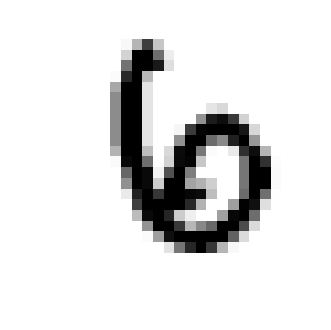

In [0]:
plt.imshow(mnist_train.iloc[3500, 1:].values.reshape(28, 28), cmap=matplotlib.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

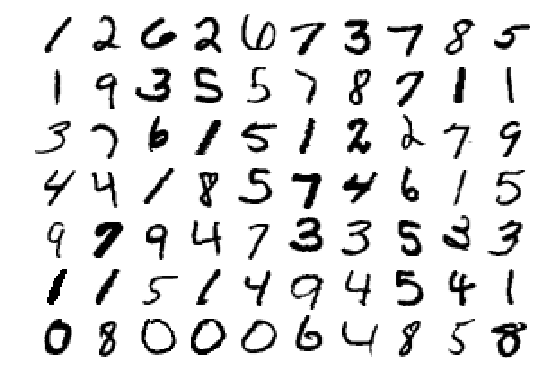

In [0]:
def plot_digits(instances, images_per_row = 10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis('off')

plt.figure(figsize=(9,9))
example_images = np.r_[mnist_train.iloc[:12000:600, 1:], mnist_train.iloc[13000:30600:600, 1:], mnist_train.iloc[30600:60000:590, 1:]]
plot_digits(example_images, images_per_row=10)
plt.show()

#### Numeric Parameter Histograms

The discriptive statistic analysis already indicated good coverage across digits in the training file, and a histogram visualizes that distribution.

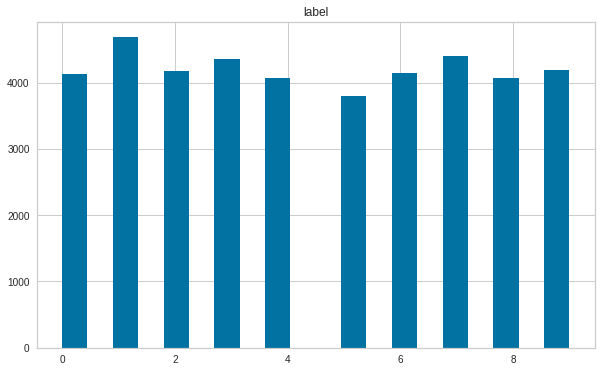

In [0]:
mnist_train[['label']].hist(bins=20, figsize=(10,6))
plt.show()

By examining a Histogram of the pixel values, we can see that the data ranges from 0-255, indicating that it is grayscale as opposed to 0 or 1 for black and white.

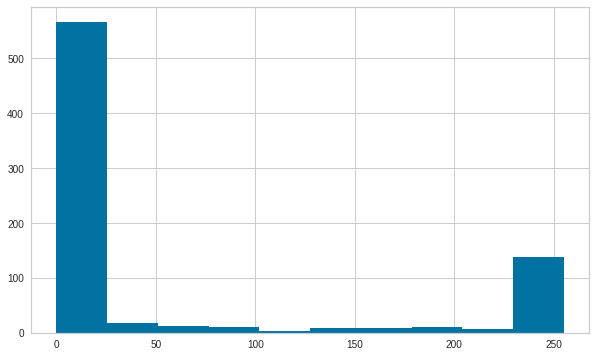

In [0]:
mnist_train.iloc[:, 1:].iloc[1].hist(figsize=(10,6))
plt.show()

#### Construct Average Digit Images

First we can examine what the average digit looks like

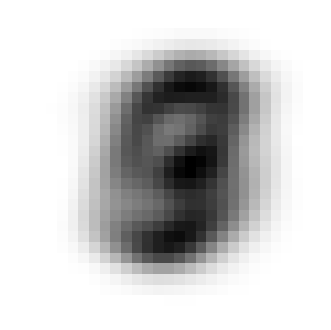

In [0]:
plt.imshow(mnist_train.mean().iloc[1:].values.reshape(28, 28), cmap=matplotlib.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

Here we can construct average images for the 10 digits by taking the mean of all images with the same label

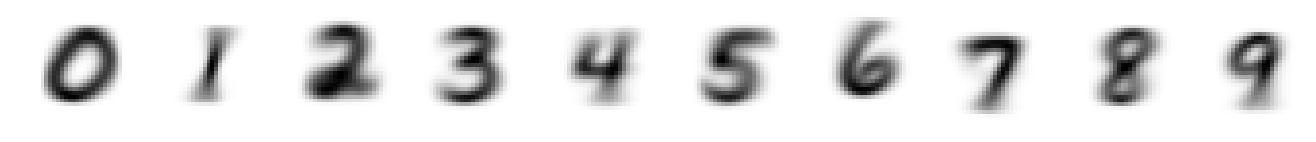

In [0]:
fig = plt.figure(figsize=(23,5))
digit_count=len(mnist_train.groupby('label').mean())
for i in range(digit_count):
  fig.add_subplot(1,digit_count,i+1)
  plt.imshow(mnist_train.groupby('label').mean().iloc[i, 0:].values.reshape(28, 28), cmap=matplotlib.cm.binary, interpolation="nearest")
  plt.axis("off")

# Random Forest Model Submission 1

### Model Definition and Training

In [0]:
training_images = mnist_train.iloc[:, 1:]
training_labels = mnist_train.iloc[:, 0]

random_forest=RandomForestClassifier(max_features = 'sqrt', bootstrap = True, n_estimators = 10, random_state=RANDOM_SEED)

In [0]:
start=datetime.datetime.now()
random_forest.fit(training_images, training_labels)
end=datetime.datetime.now()
r1_traintime=end-start
print("Time required to fit",r1_traintime)
print("Score:",random_forest.score(training_images, training_labels))

Time required to fit 0:00:03.836718
Score: 0.9991190476190476


In [0]:
visualizer = ClassificationReport(random_forest, support = 'percent')
visualizer.fit(training_images, training_labels)
#visualizer.score(X_test, y_test)
visualizer.poof()

### Model Results and Initial Submission

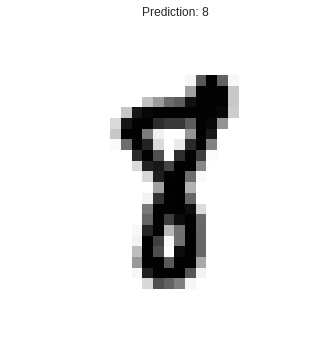

In [0]:
r1_submission = pd.DataFrame()
r1_submission['Label'] = random_forest.predict(mnist_test)
r1_submission.index += 1
r1_submission.index.name = 'ImageId'
plt.imshow(mnist_test.iloc[12121, :].values.reshape(28, 28), cmap=matplotlib.cm.binary, interpolation="nearest")
plt.title('Prediction: {}'.format(r1_submission.iloc[12121, 0]))
plt.axis("off")
plt.show()

The average images generated by the model on the test dataset are clearly identifiable as 0-9

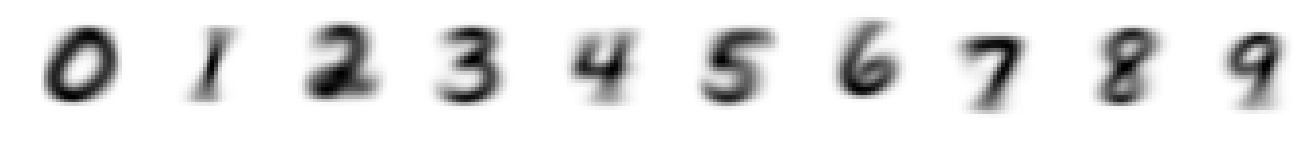

In [0]:
fig = plt.figure(figsize=(23,5))

r1_submission_results=mnist_test.copy()
r1_submission_results['label']=r1_submission['Label'].values
digit_count=len(r1_submission_results.groupby('label').mean())

for i in range(digit_count):
  fig.add_subplot(1,digit_count,i+1)
  plt.imshow(r1_submission_results.groupby('label').mean().iloc[i, 0:].values.reshape(28, 28), cmap=matplotlib.cm.binary, interpolation="nearest")
  plt.axis("off")

Save results to Google Drive

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

r1_submission.to_csv('/content/gdrive/My Drive/MSDS-422-Gift/module_5/r1_submission.csv')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


This data was submitted to Kaggle under the username ericpierce, and resulted in a score of 0.94242

# Principal Component Analysis

### Initialize Combined Dataset

In [0]:
from sklearn.decomposition import PCA

mnist_total_prescale = mnist_test.copy().append(mnist_train.copy().iloc[:,1:])
mnist_total_prescale.shape

(70000, 784)

In [0]:
mnist_total_prescale.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


While Random Forests don't require scaling, the PCA process does

In [0]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
mnist_total = scaler.fit_transform(mnist_total_prescale.astype(float))

### Conduct PCA

In [0]:
pca = PCA(n_components=0.95, random_state=RANDOM_SEED)

start=datetime.datetime.now()
mnist_reduced = pca.fit_transform(mnist_total)
end=datetime.datetime.now()
print("Time required to fit",end-start)

Time required to fit 0:00:14.464985


### Results of PCA

In [0]:
sum(pca.explained_variance_ratio_)

0.9500311796713794

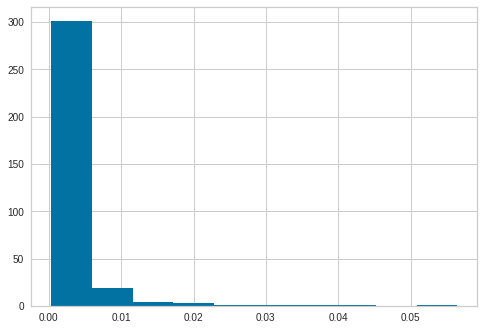

In [0]:
plt.hist(pca.explained_variance_ratio_, bins=10)
plt.show()

In [0]:
mnist_train_pca = pca.transform(training_images)

In [0]:
mnist_train_pca.shape

(42000, 332)

In [0]:
pd.DataFrame(mnist_train_pca).head()

,0,1,2,3,4,5,6,7,8,9,...,322,323,324,325,326,327,328,329,330,331
0,111.556031,-515.380019,393.325986,-422.646161,-106.158783,715.515430,8.391745,-299.059986,376.455725,-707.381371,...,-32.018353,1.377294,-31.798992,-22.947709,7.197356,12.609094,-34.125341,-3.471179,22.962898,-5.478403
1,2318.640969,320.199678,89.564563,-682.413483,-537.974538,315.099803,-836.867802,230.513885,-92.785597,-944.623214,...,-31.377974,33.108946,-2.740220,-22.188909,-25.335172,-43.155438,7.886460,25.084911,-51.126847,2.595640
2,-119.201624,-252.215344,184.683132,-117.126977,-137.479373,87.646222,-520.076448,377.278478,427.101502,-540.041861,...,-3.587095,11.011712,24.379383,-23.330191,-9.075096,-29.655765,10.669068,-14.363629,-15.958419,-13.770153
3,545.496856,300.038990,-31.310611,137.969638,-445.094951,575.075978,-40.413723,105.534642,209.500957,-66.778682,...,27.715134,44.959831,22.965528,34.551195,45.163553,31.479478,-65.870982,-17.325779,38.635335,44.878420
4,2732.203891,273.134787,53.998155,-830.536037,-164.812514,280.665451,-956.703919,84.970430,-120.301759,-990.893395,...,12.808796,80.394669,0.314415,98.923561,-32.371599,-38.162853,-13.569534,0.675837,-36.143435,20.688108


# Random Forest Model Submission 2

### Initialize PCA Random Forest Classifier

In [0]:
random_forest_pca=RandomForestClassifier(max_features = 'sqrt', bootstrap = True, n_estimators = 10, random_state=RANDOM_SEED)

In [0]:
start=datetime.datetime.now()
random_forest_pca.fit(mnist_train_pca, training_labels)
end=datetime.datetime.now()
r2_traintime=end-start
print("Time required to fit",r2_traintime)
print("Score:",random_forest_pca.score(mnist_train_pca, training_labels))

Time required to fit 0:00:11.191414
Score: 0.9989761904761905


### Model Results and Second Submission

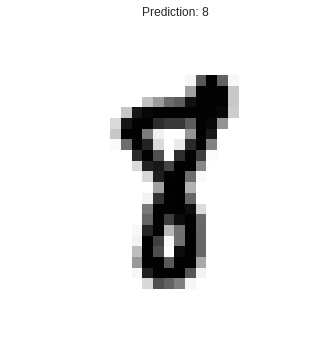

In [0]:
r2_submission = pd.DataFrame()
r2_submission['Label'] = random_forest_pca.predict(pca.transform(mnist_test))
r2_submission.index += 1
r2_submission.index.name = 'ImageId'
plt.imshow(mnist_test.iloc[12121, :].values.reshape(28, 28), cmap=matplotlib.cm.binary, interpolation="nearest")
plt.title('Prediction: {}'.format(r2_submission.iloc[12121, 0]))
plt.axis("off")
plt.show()

The average score images here are similar

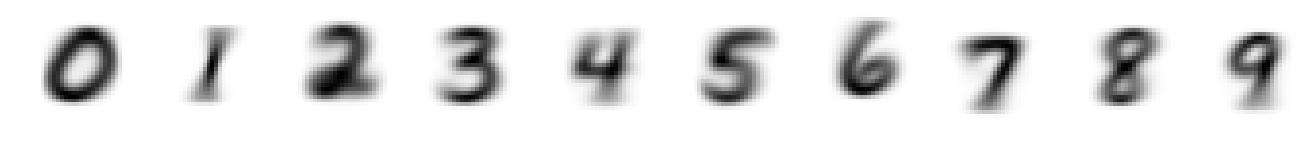

In [0]:
fig = plt.figure(figsize=(23,5))

r2_submission_results=mnist_test.copy()
r2_submission_results['label']=r2_submission['Label'].values
digit_count=len(r2_submission_results.groupby('label').mean())

for i in range(digit_count):
  fig.add_subplot(1,digit_count,i+1)
  plt.imshow(r2_submission_results.groupby('label').mean().iloc[i, 0:].values.reshape(28, 28), cmap=matplotlib.cm.binary, interpolation="nearest")
  plt.axis("off")

Save results to Google Drive

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

r2_submission.to_csv('/content/gdrive/My Drive/MSDS-422-Gift/module_5/r2_submission.csv')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


This data was submitted to Kaggle under the username ericpierce, and resulted in a score of 0.88157

# PCA Correction and Random Forest Model Submission 3

Our PCA corrected feature reduction scored lower than our full dataset, and took longer. The purpose of PCA is to reduce features needed and not overfit. This time we'll use a much lower component count to try to avoid overfitting.

Another step that was skipped earlier was training the PCA on the entire dataset, rather than a subset of the training set.

### Conduct Corrected PCA

In [0]:
from sklearn.model_selection import train_test_split

pca_corrected = PCA(n_components=0.95, random_state=RANDOM_SEED)

scaler_corrected = StandardScaler()

training_images_scaled = scaler_corrected.fit_transform(training_images.astype(float))

x_pca_train, x_pca_test, y_pca_train, y_pca_test = train_test_split(training_images_scaled, training_labels, random_state=RANDOM_SEED)

start=datetime.datetime.now()
x_pca_train_transformed = pca_corrected.fit_transform(x_pca_train)
end=datetime.datetime.now()
print("Time required to fit",end-start)

Time required to fit 0:00:07.012874


### Results of Corrected PCA

In [0]:
sum(pca_corrected.explained_variance_ratio_)

0.9502330819287848

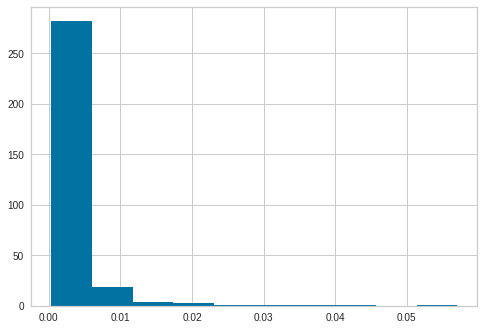

In [0]:
plt.hist(pca_corrected.explained_variance_ratio_, bins=10)
plt.show()

In [0]:
x_pca_train_transformed.shape

(31500, 313)

In [0]:
pd.DataFrame(x_pca_train_transformed).head()

,0,1,2,3,4,5,6,7,8,9,...,303,304,305,306,307,308,309,310,311,312
0,-6.025583,7.072394,-5.583653,-0.906020,2.176660,-1.715088,2.555869,3.663239,-1.845622,-2.609548,...,-0.249887,-0.113351,-0.563969,-0.418323,-0.057355,-0.395330,-0.837239,0.186158,0.055588,-0.417887
1,-3.541280,-6.281570,-0.518463,-3.258764,-2.060592,4.484329,-3.522536,-1.544705,0.884610,-3.763372,...,-0.282289,-0.372159,0.505148,0.433154,0.216698,-0.089895,0.420537,0.075463,-0.274258,-0.338482
2,4.798834,12.598354,-1.370398,5.516975,-2.315825,6.287403,6.197454,-1.624107,4.114841,-0.238254,...,-0.380048,-0.049830,-0.387266,-0.737764,0.057723,1.893318,-0.417669,-0.039641,0.040118,-0.174317
3,-3.486557,-7.775906,-1.559795,-1.673021,4.456255,1.694771,2.559371,2.407253,2.342450,2.181343,...,-0.694881,-0.064708,-0.060020,-0.643658,0.278300,0.409916,-0.869824,0.071110,-0.129766,-0.144434
4,0.990661,-6.793943,3.229550,9.700226,-8.461758,-0.682198,2.597801,4.386194,6.302550,-5.376540,...,-0.007225,0.375308,-0.265340,0.008643,-0.334381,-0.213911,0.003638,0.293049,-0.484196,-0.131207


In [0]:
random_forest_pca_corrected=RandomForestClassifier(max_features = 'sqrt', bootstrap = True, n_estimators = 100, random_state=RANDOM_SEED)

In [0]:
x_pca_test_pca_corrected = pca_corrected.transform(x_pca_test)
start=datetime.datetime.now()
random_forest_pca_corrected.fit(x_pca_train_transformed, y_pca_train)
end=datetime.datetime.now()
r3_traintime=end-start
print("Time required to fit",r3_traintime)
print("Score:",random_forest_pca_corrected.score(x_pca_test_pca_corrected, y_pca_test))

Time required to fit 0:01:12.613098
Score: 0.9316190476190476


### Model Results and Final Submission

In [0]:
r3_submission = pd.DataFrame()

r3_submission['Label'] = random_forest_pca_corrected.predict(pca_corrected.transform(scaler_corrected.transform(mnist_test.astype(float))))
r3_submission.index += 1
r3_submission.index.name = 'ImageId'
plt.imshow(mnist_test.iloc[12121, :].values.reshape(28, 28), cmap=matplotlib.cm.binary, interpolation="nearest")
plt.title('Prediction: {}'.format(r3_submission.iloc[12121, 0]))
plt.axis("off")
plt.show()

The average score images here are similar

In [0]:
fig = plt.figure(figsize=(23,5))

r3_submission_results=mnist_test.copy()
r3_submission_results['label']=r2_submission['Label'].values
digit_count=len(r3_submission_results.groupby('label').mean())

for i in range(digit_count):
  fig.add_subplot(1,digit_count,i+1)
  plt.imshow(r3_submission_results.groupby('label').mean().iloc[i, 0:].values.reshape(28, 28), cmap=matplotlib.cm.binary, interpolation="nearest")
  plt.axis("off")

Save results to Google Drive

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

r3_submission.to_csv('/content/gdrive/My Drive/MSDS-422-Gift/module_5/r3_submission.csv')

This data was submitted to Kaggle under the username ericpierce, and resulted in a score of 0.93200

In [0]:
results_df = pd.DataFrame({'TestName': ['Random Forest with no PCA', 'Random Forest with PCA', 'Corrected Random Forest with PCA'],
   'TestScore': [0.94242, 0.88157, 0.93200],
   'TestTimeToFit': [r1_traintime, r2_traintime, r3_traintime]})
results_df.set_index('TestName', inplace=True)

results_df

,TestScore,TestTimeToFit
TestName,,
Random Forest with no PCA,0.94242,00:00:03.836718
Random Forest with PCA,0.88157,00:00:11.191414
Corrected Random Forest with PCA,0.93200,00:01:12.613098


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_core.py:223: FutureWarning: Passing integers to fillna is deprecated, will raise a TypeError in a future version.  To retain the old behavior, pass pd.Timedelta(seconds=n) instead.
  data = data.fillna(fillna)


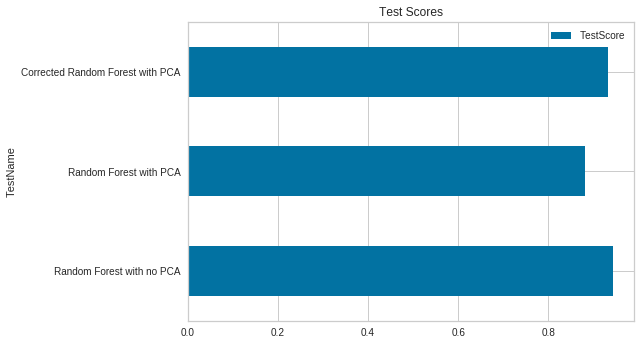

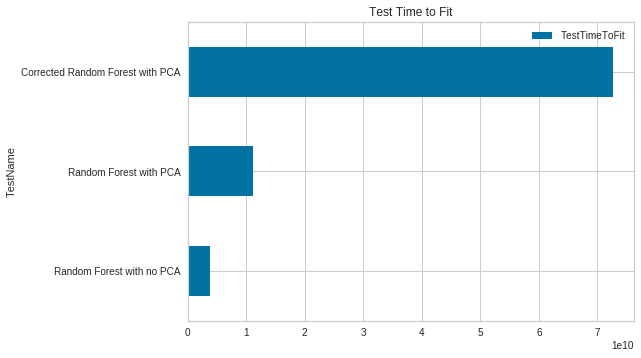

In [0]:
results_df[['TestScore']].plot(kind='barh', title='Test Scores')
results_df[['TestTimeToFit']].plot(kind='barh', title='Test Time to Fit')
plt.show()

# Recommendations

The results of this particular dataset indicated that the PCA process did not significantly reduce time to train (in fact it significantly incresed it), and it had a minor impact on the ultimate score (about 1% less accurate).